In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
tf.reset_default_graph()

In [0]:
np.random.seed(42)
tf.set_random_seed(42)

In [7]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


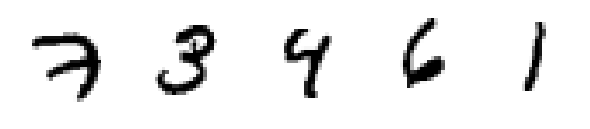

In [8]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [9]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

In [0]:
#Input layer
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

**Primary 2 layer CNN for generating the activation vectors **

In [0]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

In [0]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [0]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

**Note: since we used a kernel size of 9 and no padding (for some reason, that's what "valid" means), the image shrunk by 9-1=8 pixels after each convolutional layer (28×28 to 20×20, then 20×20 to 12×12), and since we used a stride of 2 in the second convolutional layer, the image size was divided by 2. This is how we end up with 6×6 feature maps.
Next, we reshape the output to get a bunch of 8D vectors representing the outputs of the primary capsules. The output of conv2 is an array containing 32×8=256 feature maps for each instance, where each feature map is 6×6. So the shape of this output is (batch size, 6, 6, 256). We want to chop the 256 into 32 vectors of 8 dimensions each. We could do this by reshaping to (batch size, 6, 6, 32, 8). However, since this first capsule layer will be fully connected to the next capsule layer, we can simply flatten the 6×6 grids. This means we just need to reshape to (batch size, 6×6×32, 8).**

In [0]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

In [0]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [16]:
caps1_output = squash(caps1_raw, name="caps1_output")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


**Digit Capsule to compute the output of the digit capsules, we must first compute the predicted output vectors (one for each primary / digit capsule pair). Then we can run the routing by agreement algorithm.
Compute the Predicted Output Vectors
The digit capsule layer contains 10 capsules (one for each digit) of 16 dimensions each:**

In [0]:
caps2_n_caps = 10
caps2_n_dims = 16

In [0]:
init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [0]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [0]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

In [21]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [22]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

In [23]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

**Routing by agreement**

In [24]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

Instructions for updating:
dim is deprecated, use axis instead


In [0]:
caps2_output = caps2_output_round_2

In [26]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


**Estimated Class Probabilities (Length)**

In [0]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [0]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [0]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

**Margin Loss**

In [30]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
T = tf.one_hot(y, depth=caps2_n_caps, name="T")
with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [0]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

**Reconstruction as regularization**

In [0]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

**Decoder unit of reconstruction**

In [0]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

**Reconstruction loss parameterized by alpha nealry 0.00005**

In [0]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

In [0]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

**Training :/ **

In [0]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")
init = tf.global_variables_initializer()
saver = tf.train.Saver()

**Training
Training our capsule network is pretty standard. For simplicity, we won't do any fancy hyperparameter tuning, dropout or anything, we will just run the training operation over and over again, displaying the loss, and at the end of each epoch, measure the accuracy on the validation set, display it, and save the model if the validation loss is the lowest seen found so far (this is a basic way to implement early stopping, without actually stopping). Hopefully the code should be self-explanatory, but here are a few details to note:
if a checkpoint file exists, it will be restored (this makes it possible to interrupt training, then restart it later from the last checkpoint),
we must not forget to feed mask_with_labels=True during training,
during testing, we let mask_with_labels default to False (but we still feed the labels since they are required to compute the accuracy),
the images loaded via mnist.train.next_batch() are represented as float32 arrays of shape [784], but the input placeholder X expects a float32 array of shape [28, 28, 1], so we must reshape the images before we feed them to our model,
we evaluate the model's loss and accuracy on the full validation set (5,000 instances). To view progress and support systems that don't have a lot of RAM, the code evaluates the loss and accuracy on one batch at a time, and computes the mean loss and mean accuracy at the end.
Warning: if you don't have a GPU, training will take a very long time (at least a few hours). **

In [37]:
n_epochs = 5
batch_size = 100
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 98.6000%  Loss: 0.018462 (improved)
Epoch: 2  Val accuracy: 99.1800%  Loss: 0.011938 (improved)
Epoch: 3  Val accuracy: 99.2600%  Loss: 0.009612 (improved)
Epoch: 4  Val accuracy: 99.3000%  Loss: 0.009151 (improved)
Epoch: 5  Val accuracy: 99.3400%  Loss: 0.007950 (improved)


**Evaluation**

In [38]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 99.3800%  Loss: 0.007606


**Predictions**

INFO:tensorflow:Restoring parameters from ./my_capsule_network


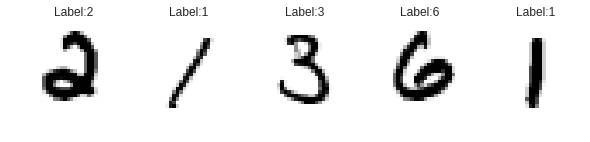

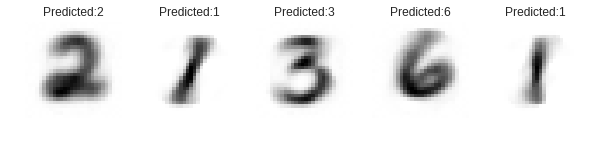

In [39]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()

**Interpreting the output vectors (totally 3rd level) **

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Tweaking output dimension #0


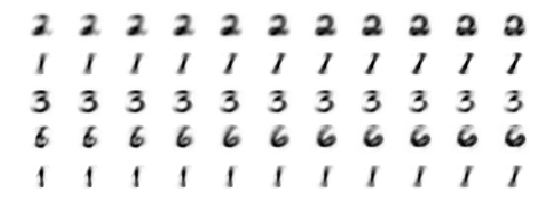

Tweaking output dimension #1


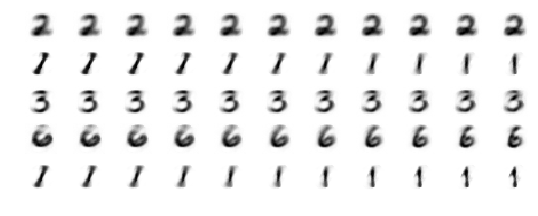

Tweaking output dimension #2


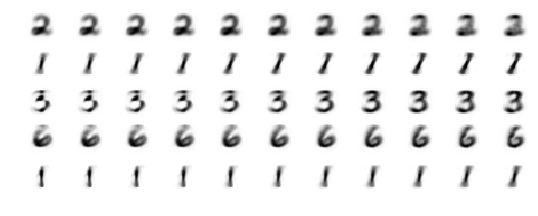

In [40]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()